Import packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Boundary value problem (BVP) with Neumann Boundary Condition

In this tutorial, we solve a boundary-value problem with a Neumann boundary condition using both a backward-difference scheme and a ghost-point central-difference scheme, then compare their accuracy.

We use the following example problem: 

and thermal conductivity $k$. Suppose the rod has a constant volumetric heat source $Q$. The temperature distribution in the rod is governed by the steady-state heat equation:

$ -k\frac{d^2T}{dx^2} = Q $

or equivalently

$ \frac{d^2T}{dx^2} = -\frac{Q}{k} \equiv - S, \quad S >0 $

The right side of the rod is insulated, therefore, the heat flux is zero:

$\left.\frac{dT}{dx}\right|_{x=L} = 0$ (Neumann BC)

The left side of the rod is in contact with a heat source, maintaining a constant temperature:

$ T(x=0) = T_{start} $

We will let :

$ L = 0.5 $ m

$ S = 2 \times 10^{4}$ K/m $^2$

$ T_{start} = 373 $ K (100 $^\circ \text{C}$)

We discretize the interior points of the system using the central‐difference scheme.

$ T_{i-1} - 2T_i + T_{i-1} = -S h^{2}, \quad \forall i \in [1,N-2]$ and $T_0 =  T_{start}$



#### 1. Neumann boundary condition discretization with backward difference scheme

$\left.\frac{dT}{dx}\right|_{x=L} = \frac{T_{N-1}-T_{N-2}}{h} = 0$

This simplifies to $T_{N-1} = T_{N-2}$

We build the system matrix using option 2 presented in the lecture where we solve a reduced system for only the interior nodes.

$ -2T_1 + T_2 = -T_{start}-Sh^2$

$T_{i-1} -2T_i+T_{i+1}= -Sh^2, \quad \forall i \in [2, N-3]$

$ T_{N-3} - T_{N-2} = -Sh^2 $


Define parameters.

In [2]:
L = 0.5 #m
Tstart = 373 # K
S = 2e4 #K/m2

Define function to define and solve the system of equations

In [3]:
def solveT_backward_diff(nsteps, L, Tstart):

    """
    Solve the 1D steady-state heat equation with constant volumetric source
    and an insulated (Neumann) boundary at the right end using backward difference.

    Parameters:
        nsteps (int):   Number of grid points along the rod
        L (float):      Total length of the rod
        Tstart (float): Temperature at the left boundary (Dirichlet condition)

    Returns:
        x (ndarray): Grid coordinates (0 to L)
        T (ndarray): Temperature at each grid point
    """

    # Generate spatial grid and compute step size
    x = np.linspace(0, L, nsteps)
    h = x[1] - x[0]

    # Set up linear system A * T = b for interior nodes only
    # A is of size (nsteps-2) x (nsteps-2) corresponding to nodes 1..nsteps-2
    A = np.zeros((len(x)-2, len(x)-2))

    # Fill main diagonal with -2 
    A -= 2 * np.eye(len(A))

    # Fill sub- and super-diagonals with +1 for the second derivative stencil
    #   i-1 term
    A += np.tri(len(A), k=-1) - np.tri(len(A), k=-2)
    #   i+1 term
    A += np.tri(len(A), k=1)  - np.tri(len(A), k=0)

    # Modify the last row for backward difference Neumann BC:
    # Enforce (T_{N-1} - T_{N-2}) / h = 0 -> T_{N-1} = T_{N-2}
    # This yields the coefficient -1 on T_{N-2}
    A[-1, -1] = -1

    # Construct right-hand side vector b 
    b = np.ones(len(x)-2) * (-S * h**2)
    b[0] = -Tstart - S * h**2

    # Initialize full solution array
    T = np.zeros(len(x))
    T[0] = Tstart

    # Solve for interior temperatures
    T[1:-1] = np.linalg.solve(A, b)

    # Enforce insulated boundary at right end via backward difference
    T[-1] = T[-2]

    return x, T



Numerical solution

In [4]:
nsteps = 31 # number of steps to use for discretization
x, T =  solveT_backward_diff(nsteps,L,Tstart)

Analytical solution

In [5]:
T_ana = np.zeros(len(T))
T_ana = Tstart + S*(L*x-0.5*x**2)

Plot results

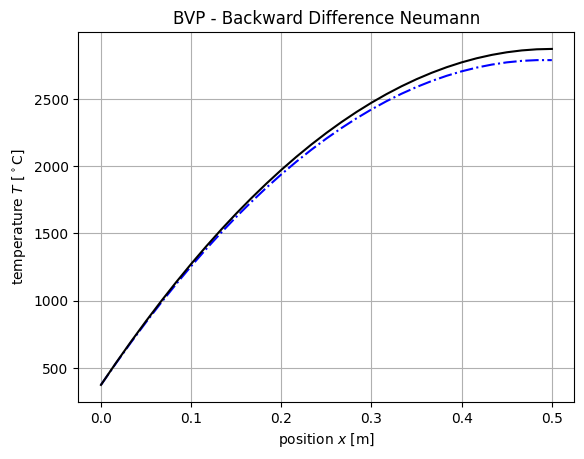

In [6]:
fig  = plt.figure()
plt.plot(x, T,color='b', linestyle='dashdot', label='numerical')
plt.plot(x,T_ana,color='k',label = 'analytical')
plt.xlabel("position $x$ [m]")
plt.ylabel("temperature $T$ [$^\circ$C]")
plt.title("BVP - Backward Difference Neumann")
plt.grid()
plt.show()


Grid refinement study

In [7]:
results = []
for nsteps in [11, 21, 41, 81, 161]:

    # Compute numerical solution
    x,T_num  = solveT_backward_diff(nsteps,L,Tstart)
    h = L / (nsteps-1)

    # Analytical solution
    T_ana = Tstart + S*(L*x-0.5*x**2)

    # Absolute error between numerical and analytical solution
    error = np.max(np.abs(T_num - T_ana))

    results.append((nsteps, h, error))

# Compute observed order of convergence
print('Grid refinement study results:')
print('-------------------------------')

df = pd.DataFrame(results, columns=['nsteps', 'h', 'error'])
df['order'] = np.round(np.log(df['error'] / df['error'].shift(1)) / np.log(df['h'] / df['h'].shift(1)))
df = df.round(4).set_index('nsteps')
print(df)

Grid refinement study results:
-------------------------------
             h    error  order
nsteps                        
11      0.0500  250.000    NaN
21      0.0250  125.000    1.0
41      0.0125   62.500    1.0
81      0.0062   31.250    1.0
161     0.0031   15.625    1.0


#### 2. Neumann boundary condition discretization with central difference scheme

$\left.\frac{dT}{dx}\right|_{x=L} = \frac{T_{N}-T_{N-2}}{2h} = 0$

This simplifies to $T_{N} = T_{N-2}$

We build the system matrix using option 2 presented in the lecture where we solve a reduced system for only the interior nodes.

$ -2T_1 + T_2 = -T_{start}-Sh^2$

$T_{i-1} -2T_i+T_{i+1}= -Sh^2, \quad \forall i \in [2, N-3]$

$ 2T_{N-2} - 2T_{N-1} = -Sh^2 $


Define function to define and solve the system of equations

In [8]:
def solveT_central_diff(nsteps,L,Tstart):

    """
    Solve the 1D steady-state heat equation with constant volumetric source
    and an insulated (Neumann) boundary at the right end using central difference (ghost-node) for second-order accuracy.

    Parameters:
        nsteps (int):   Number of grid points along the rod
        L (float):      Total length of the rod
        Tstart (float): Temperature at the left boundary (Dirichlet condition)

    Returns:
        x (ndarray): Grid coordinates (0 to L)
        T (ndarray): Temperature at each grid point
    """

    # Generate spatial grid and compute step size
    x = np.linspace(0, L, nsteps)
    h = x[1] - x[0] 

    # Set up linear system A * T = b for interior nodes only
    # A is of size (nsteps-1) x (nsteps-1) corresponding to nodes 1..nsteps-1
    A = np.zeros((len(x)-1,len(x)-1))

    # Fill main diagonal with -2 
    A -= 2*np.eye(len(A))
    
    # Fill sub- and super-diagonals with +1 for the second derivative stencil
    #   i-1 term
    A += np.tri((len(A)),k=-1)-np.tri((len(A)),k=-2)
    #   i+1 term
    A += np.tri((len(A)),k=1)-np.tri((len(A)),k=0)

    # Modify the last row for backward difference Neumann BC:
    # Enforce (T_{N} - T_{N-2}) / 2h = 0 -> T_{N} = T_{N-2}
    # This yields the coefficient 2 on T_{N-2}
    A[-1,-2] = 2

    # Construct right-hand side vector b 
    b = np.ones(len(x)-1)*(-S*h**2)
    b[0] = - Tstart - S*h**2

    # Initialize full solution array
    T = np.zeros(len(x))
    T[0] = Tstart # boundary value

    # Solve for interior temperatures and assign
    T[1:] = np.linalg.solve(A,b)

    return x, T 

Numerical solution

In [9]:
nsteps = 31 # number of steps to use for discretization
x, T =  solveT_central_diff(nsteps,L,Tstart)

Analytical solution

In [10]:
T_ana = np.zeros(len(T))
T_ana = Tstart + S*(L*x-0.5*x**2)

Plot results

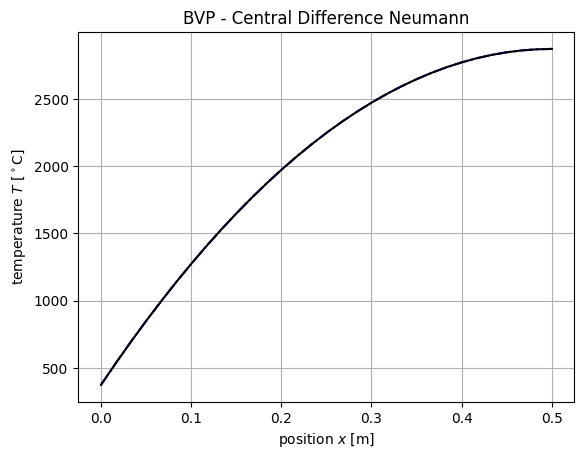

In [11]:
fig  = plt.figure()
plt.plot(x, T,color='b', linestyle='dashdot', label='numerical')
plt.plot(x,T_ana,color='k',label = 'analytical')
plt.xlabel("position $x$ [m]")
plt.ylabel("temperature $T$ [$^\circ$C]")
plt.title("BVP - Central Difference Neumann")
plt.grid()
plt.show()

Grid refinement study

In [12]:
results = []
for nsteps in [11, 21, 41, 81, 161]:

    # Compute numerical solution
    x,T_num  = solveT_central_diff(nsteps,L,Tstart)
    h = L / (nsteps-1)

    # Analytical solution
    T_ana = Tstart + S*(L*x-0.5*x**2)

    # Absolute error between numerical and analytical solution
    error = np.max(np.abs(T_num - T_ana))

    results.append((nsteps, h, error))

# Compute observed order of convergence
print('Grid refinement study results:')
print('-------------------------------')

df = pd.DataFrame(results, columns=['nsteps','h','error'])
df[['h','error']] = df[['h','error']].round(4)
print(df)

Grid refinement study results:
-------------------------------
   nsteps       h  error
0      11  0.0500    0.0
1      21  0.0250    0.0
2      41  0.0125    0.0
3      81  0.0062    0.0
4     161  0.0031    0.0


Because the exact solution for $T$ is a quadratic in $x$ and a second-order finite-difference stencil reproduces any quadratic exactly, the numerical and analytic solutions coincide, resulting in zero error, independent of the grid resolution.
